In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import os

In [3]:
organism = 'mm10'
dataset = 'Zhang_PNAS_2014'

# MARA model $E_{pc} = \sum_m N_{pm} A_{mc}$

## From ismara

In [4]:
ismara_path = f"/home/jbreda/RNAseq/results/{dataset}/ismara_report"
expression_table = pd.read_csv(f"{ismara_path}/expression_table", sep='\t', index_col=0)
activity_table = pd.read_csv(f"{ismara_path}/activity_table", sep='\t', index_col=0)

## Get data

In [46]:
# Load data
window_kb = 1

# site count matrix
site_count_matrix_infile = 'results/mm10/site_count_matrix_Jasper_pm1kb.txt'
if os.path.exists(site_count_matrix_infile):
    N_pm = torch.from_numpy( np.loadtxt(site_count_matrix_infile, delimiter='\t')).to(dtype=torch.float32)
else:
    site_count_matrix = torch.load(f'/home/jbreda/Jaspar/results/mm10/Window_pm{window_kb}kb/convolution_PromSeq_PWM.pt')
    site_count_matrix[site_count_matrix < 0.5] = 0
    N_pm = torch.sum(site_count_matrix, dim=2)
    # Write N_pm to text file
    np.savetxt(site_count_matrix_infile, N_pm, fmt='%f', delimiter='\t')

infile_jaspar_clusters_to_tf = '/home/jbreda/Jaspar/resources/interactive_trees/JASPAR_2022_matrix_clustering_vertebrates_CORE_tables/clusters_motif_names.tab'
clusters_to_tf = pd.read_csv(infile_jaspar_clusters_to_tf,sep='\t',header=None)

promoterome = pd.read_csv(f'/home/jbreda/Promoterome/results/mm10/promoterome_pm{window_kb}kb_filtered.bed', sep='\t',index_col=-1)

In [47]:


# Promoter expression matrix
infile = f'/home/jbreda/RNAseq/results/{dataset}/kallisto/promoter_mrna_table.tab'
tmp1 = pd.read_csv(infile, sep='\t', index_col=0)
infile = f'/home/jbreda/RNAseq/results/{dataset}/kallisto/promoter_premrna_table.tab'
tmp2 = pd.read_csv(infile, sep='\t', index_col=0)
tmp = tmp1 + tmp2
del tmp1, tmp2
# get only the promoters that are in the promoterome
tmp = tmp.loc[np.intersect1d(promoterome.index,tmp.index)]

# Promoter expression matrix in the same space as the promoterome
promoter_expression = pd.DataFrame(index=promoterome.index, columns=tmp.columns)
promoter_expression.values[:] = 0
promoter_expression.loc[tmp.index] = tmp
del tmp

E_ps = torch.tensor(np.log2(promoter_expression.values.astype(np.float32)+1), dtype=torch.float32)
# centering
E_ps -= torch.mean(E_ps, dim=0, keepdim=True)
E_ps -= torch.mean(E_ps, dim=1, keepdim=True)
N_pm -= torch.mean(N_pm, dim=0, keepdim=True)


In [48]:

#infile_jaspar_clusters_tf_corr = '/home/jbreda/Jaspar/resources/interactive_trees/JASPAR_2022_matrix_clustering_vertebrates_CORE_tables/pairwise_compa.tab'
#clusters_tf_corr = pd.read_csv(infile_jaspar_clusters_tf_corr,sep='\t',low_memory=False)
mm10_tf_list = '/bigdata/jbreda/genome/mm10/mm10_TF_list.csv'
TFs = pd.read_csv(mm10_tf_list, header=None,sep='\t')

In [49]:

I = np.zeros([len(clusters_to_tf),len(TFs)],dtype=bool)
for i in clusters_to_tf.index:
    for j in TFs.index:
        if TFs.loc[j,1].lower() in clusters_to_tf.loc[i,1].lower().split(','):
            I[i,j] = True


#clusters_to_tf.loc[:,'mm10'] = ''
for c in clusters_to_tf.index:
    clusters_to_tf.loc[c,'mm10'] = ','.join(np.sort(TFs.iloc[I[c,:],1]))

tf_to_cluster = {}
#for i,j



In [62]:
I

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# Least square regression

In [50]:
# least square regression beta = (X^T X)^-1 X^T y
C = torch.inverse(N_pm.T @ N_pm)
beta = C @ N_pm.T @ E_ps
S = np.square(E_ps - N_pm @ beta).sum()
n = np.prod(E_ps.shape)
m = np.prod(beta.shape)
sigma2 = S/(n-m) # unbiased estimate of the variance
var_beta = sigma2 * np.diag(C)

# fraction of variance explained
R2 = 1 - S / np.square(E_ps).sum()

print(f"R2 = {R2:.3f}")

R2 = 0.034


In [53]:
# define the model
class MARA(nn.Module):
    # define the elements of the model
    def __init__(self, input_dim, output_dim):
        super(MARA, self).__init__()
        self.matmul = nn.Linear(input_dim, output_dim, bias=False)
    
    # define the forward pass
    def forward(self, x):
        output = self.matmul(x)
        return output
    
# train
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(MARA.parameters(), lr=0.01)

TypeError: Module.parameters() missing 1 required positional argument: 'self'

In [54]:
# Define the torch model : E_ps = sum_m N_pm * W_ms


# Train the model
n_epochs = 100
batch_size = 1000
n_batches = N_pm.shape[0] // batch_size
for epoch in range(n_epochs):
    for batch in range(n_batches):
        optimizer.zero_grad()
        batch_N_pm = N_pm[batch*batch_size:(batch+1)*batch_size]
        batch_E_pm = E_pm[batch*batch_size:(batch+1)*batch_size]
        output = MARA(batch_N_pm)
        loss = criterion(output, batch_E_pm)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch} loss: {loss.item()}')

NameError: name 'optimizer' is not defined

# NN model

In [61]:

class AdvancedLinear(nn.Module):
    def __init__(self, in_features, out_features, fixed_mask=None, lambda_entropy=0.01, clamp_weights=True):
        super(AdvancedLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        #self.weight = nn.Parameter(torch.rand(out_features, in_features))
        self.weight = nn.Parameter(torch.zeros(out_features, in_features))
        #self.bias = nn.Parameter(torch.rand(out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.lambda_entropy = lambda_entropy
        self.clamp_weights = clamp_weights
        self.fixed_mask = fixed_mask if fixed_mask is not None else torch.zeros(out_features, in_features, dtype=torch.bool)

        # Initialize specific weights to 1 according to the mask
        self.weight.data[self.fixed_mask] = 1.0

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)

    def entropy_loss(self):
        probs = F.softmax(self.weight, dim=1)
        log_probs = torch.log(probs)
        entropy = -torch.sum(probs * log_probs, dim=1)
        return torch.mean(entropy) * self.lambda_entropy

    def post_update_constraints(self):
        with torch.no_grad():
            #self.weight.clamp_(0, 1)  # Clamp weights between 0 and 1
            self.weight.data[self.fixed_mask] = 1.0  # Reset fixed weights to 1

input_dim = N_pm.shape
print(input_dim)
output_dim = E_ps.shape
print(output_dim)
# Define a fixed mask where some weights are fixed
fixed_mask = torch.zeros(96, 137, dtype=torch.bool)
#fixed_mask[0, :3] = 1  # Fix the first three weights of the first row to 1

# Initialize the model with the mask
model = AdvancedLinear(input_dim[1], output_dim[1], fixed_mask=fixed_mask)
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_function = nn.MSELoss()

# Generate simulated data
torch.manual_seed(42)
#inputs = torch.randn(100, 10)
inputs = N_pm
#targets = torch.randn(100, 5)  # Assume 5 output features
targets = E_ps

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = loss_function(outputs, targets)# + model.entropy_loss()

    # Backward pass
    loss.backward()

    # Zero out gradients for fixed weights
    model.weight.grad[model.fixed_mask] = 0

    # Optimize
    optimizer.step()

    # Apply post-update constraints
    model.post_update_constraints()

    print(f'Epoch {epoch+1}, Loss: {1-loss.item()}')

# Show final weights
A_toch = model.weight

predicted = model(inputs)
R2 = 1 - torch.square(targets - predicted).sum() / torch.square(targets).sum()
print(f'R2: {R2:.3f}')

torch.Size([28807, 137])
torch.Size([28807, 96])
Epoch 1, Loss: 0.016858220100402832
Epoch 2, Loss: 0.02848982810974121
Epoch 3, Loss: 0.03186392784118652
Epoch 4, Loss: 0.03312760591506958
Epoch 5, Loss: 0.03382885456085205
Epoch 6, Loss: 0.03435957431793213
Epoch 7, Loss: 0.034821391105651855
Epoch 8, Loss: 0.035241901874542236
Epoch 9, Loss: 0.03563082218170166
Epoch 10, Loss: 0.035992324352264404
Epoch 11, Loss: 0.03632932901382446
Epoch 12, Loss: 0.03664422035217285
Epoch 13, Loss: 0.03693878650665283
Epoch 14, Loss: 0.03721487522125244
Epoch 15, Loss: 0.03747415542602539
Epoch 16, Loss: 0.03771817684173584
Epoch 17, Loss: 0.03794795274734497
Epoch 18, Loss: 0.038164734840393066
Epoch 19, Loss: 0.038369596004486084
Epoch 20, Loss: 0.03856337070465088
Epoch 21, Loss: 0.038747191429138184
Epoch 22, Loss: 0.03892159461975098
Epoch 23, Loss: 0.03908717632293701
Epoch 24, Loss: 0.03924494981765747
Epoch 25, Loss: 0.039395272731781006
Epoch 26, Loss: 0.03953874111175537
Epoch 27, Loss: 

In [24]:
print(beta.shape)
print(model.weight.shape)

torch.corrcoef(torch.concat(beta.flatten(), model.weight.T.flatten()))

torch.Size([137, 96])
torch.Size([96, 137])


TypeError: concat() received an invalid combination of arguments - got (Tensor, Tensor), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


Text(0.5, 1.0, 'rho = 0.906')

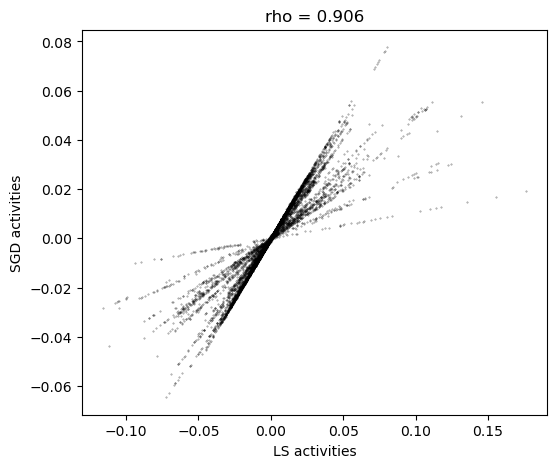

In [7]:
rho = torch.corrcoef(torch.concat([beta.flatten()[None,:], model.weight.T.flatten()[None,:]],0))[0,1]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(beta.flatten().detach().numpy(), model.weight.T.flatten().detach().numpy(), s=.5, alpha=0.5, c='black', marker='.')
ax.set_xlabel('LS activities')
ax.set_ylabel('SGD activities')
ax.set_title(f'rho = {rho:.3f}')



# Mara with distance $E_pc = \sum_{m,d} N_{pmd} e^{d^2/\sigma_m^2} A_{mc}$

In [63]:
infile = f'/home/jbreda/ChIP_atlas/results/{organism}/Peak_tensors/Window_pm5kb/Sparse_peak_tensor_prom_tf_position.pt'
Chip_peaks_prom_tf_pos = torch.load(infile)

tensor([   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,  202.4059,    0.0000,   97.0000,  406.4340,
           0.0000,  616.8927,    0.0000,    0.0000,    0.0000,  573.7841,
           0.0000,  320.6948,    0.0000,    0.0000,  367.8625,  376.3157,
         704.0371,    0.0000,    0.0000,    0.0000,    0.0000, 1286.5801,
         866.4494,  185.0000,  402.4343,  144.8689,    0.0000,    0.0000,
         157.0000,  254.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,  679.3800,    0.0000,  550.0000, 1686.9113,  512.2153,
           0.0000, 1122.5959,    0.0000,  791.3616,    0.0000,    0.0000,
         182.1695,  977.0508,  388.9476,  218.8024,  881.5103,    0.0000,
           0.0000, 2286.0000,  113.0000,  102.0000,    0.0000,    0.0000,
           0.0000,  131.0000,  306.7043,    0.0000,    0.0000,    0.0000,
           0.0000,  926.2561,    0.000